# Import libraries

In [29]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.metrics import mean_squared_log_error

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Configuration

In [2]:
COL_NAMES = [
    'Sex',
    'Length',
    'Diameter',
    'Height',
    'Whole weight',
    'Whole weight.1',
    'Whole weight.2',
    'Shell weight',
    'Rings']

NUMERICAL_COLS = ['Length',
    'Diameter',
    'Height',
    'Whole weight',
    'Whole weight.1',
    'Whole weight.2',
    'Shell weight']

CATEGORICAL_COL = ["Sex"]
SEED = 42

# Functions

In [3]:
def test_function():
    pass

# Import data

In [4]:
# Train data from Kaggle
org_train = pd.read_csv('data/train.csv')

# Orginal data from UCI
org_data = pd.read_csv('data/abalone.data', header=None, names=COL_NAMES)

In [5]:
# Enrich dataset
org_train.drop('id', axis=1, inplace=True)
df_master = pd.concat([org_train, org_data])

# Leave the original data as is
df = df_master.copy()
df.head()

,Sex,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight,Rings
0,F,0.550,0.430,0.150,0.7715,0.3285,0.1465,0.2400,11
1,F,0.630,0.490,0.145,1.1300,0.4580,0.2765,0.3200,11
2,I,0.160,0.110,0.025,0.0210,0.0055,0.0030,0.0050,6
3,M,0.595,0.475,0.150,0.9145,0.3755,0.2055,0.2500,10
4,I,0.555,0.425,0.130,0.7820,0.3695,0.1600,0.1975,9


# EDA

In [6]:
print(f'Before concat: {org_train.shape}, {org_data.shape}\n')
print(f'After concat: {df_master.shape}, {df.shape}')

Before concat: (90615, 9), (4177, 9)

After concat: (94792, 9), (94792, 9)


In [7]:
# View columns stats
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 94792 entries, 0 to 4176
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Sex             94792 non-null  object 
 1   Length          94792 non-null  float64
 2   Diameter        94792 non-null  float64
 3   Height          94792 non-null  float64
 4   Whole weight    94792 non-null  float64
 5   Whole weight.1  94792 non-null  float64
 6   Whole weight.2  94792 non-null  float64
 7   Shell weight    94792 non-null  float64
 8   Rings           94792 non-null  int64  
dtypes: float64(7), int64(1), object(1)
memory usage: 7.2+ MB


## Null & Duplicates analysis

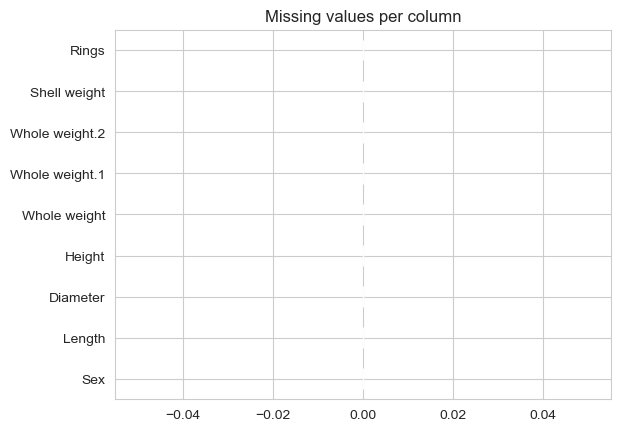

In [8]:
# Check for missing values with a horizontal bar plot
df.isnull().sum().plot(kind='barh')
plt.title('Missing values per column')
plt.show()

In [9]:
# Check for duplication
print(f'Number of duplicated records: {df.duplicated().sum()}')

Number of duplicated records: 0


## Categorical variables

In [10]:
# Select only categorical
categorical_columns = list(df.select_dtypes(include=['object']))
categorical_columns

['Sex']

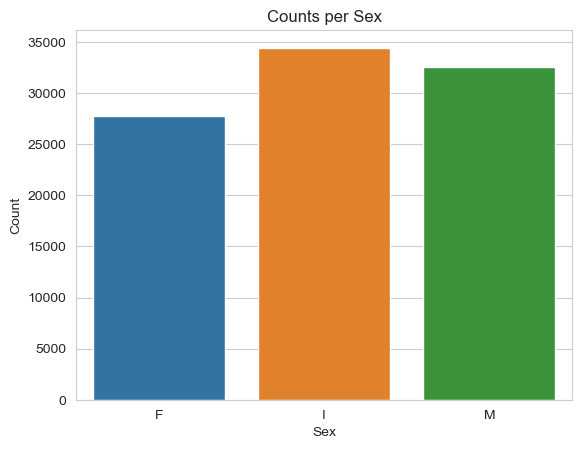

In [11]:
sns.countplot(data=df, x="Sex")
plt.title("Counts per Sex")
plt.ylabel("Count")
plt.show()

## Numerical variables

In [12]:
# Select only numerical
numerical_columns = list(df.select_dtypes(include=['float64', 'int64']))
numerical_columns

['Length',
 'Diameter',
 'Height',
 'Whole weight',
 'Whole weight.1',
 'Whole weight.2',
 'Shell weight',
 'Rings']

In [13]:
# Check statistics
df[numerical_columns].describe().round(3)

,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight,Rings
count,94792.000,94792.000,94792.000,94792.000,94792.000,94792.000,94792.000,94792.000
mean,0.517,0.402,0.136,0.791,0.342,0.170,0.226,9.707
std,0.118,0.098,0.038,0.459,0.205,0.101,0.131,3.179
min,0.075,0.055,0.000,0.002,0.001,0.000,0.002,1.000
25%,0.445,0.345,0.110,0.420,0.178,0.086,0.120,8.000
50%,0.545,0.425,0.140,0.800,0.330,0.166,0.225,9.000
75%,0.600,0.470,0.160,1.072,0.464,0.233,0.305,11.000
max,0.815,0.650,1.130,2.826,1.488,0.760,1.005,29.000


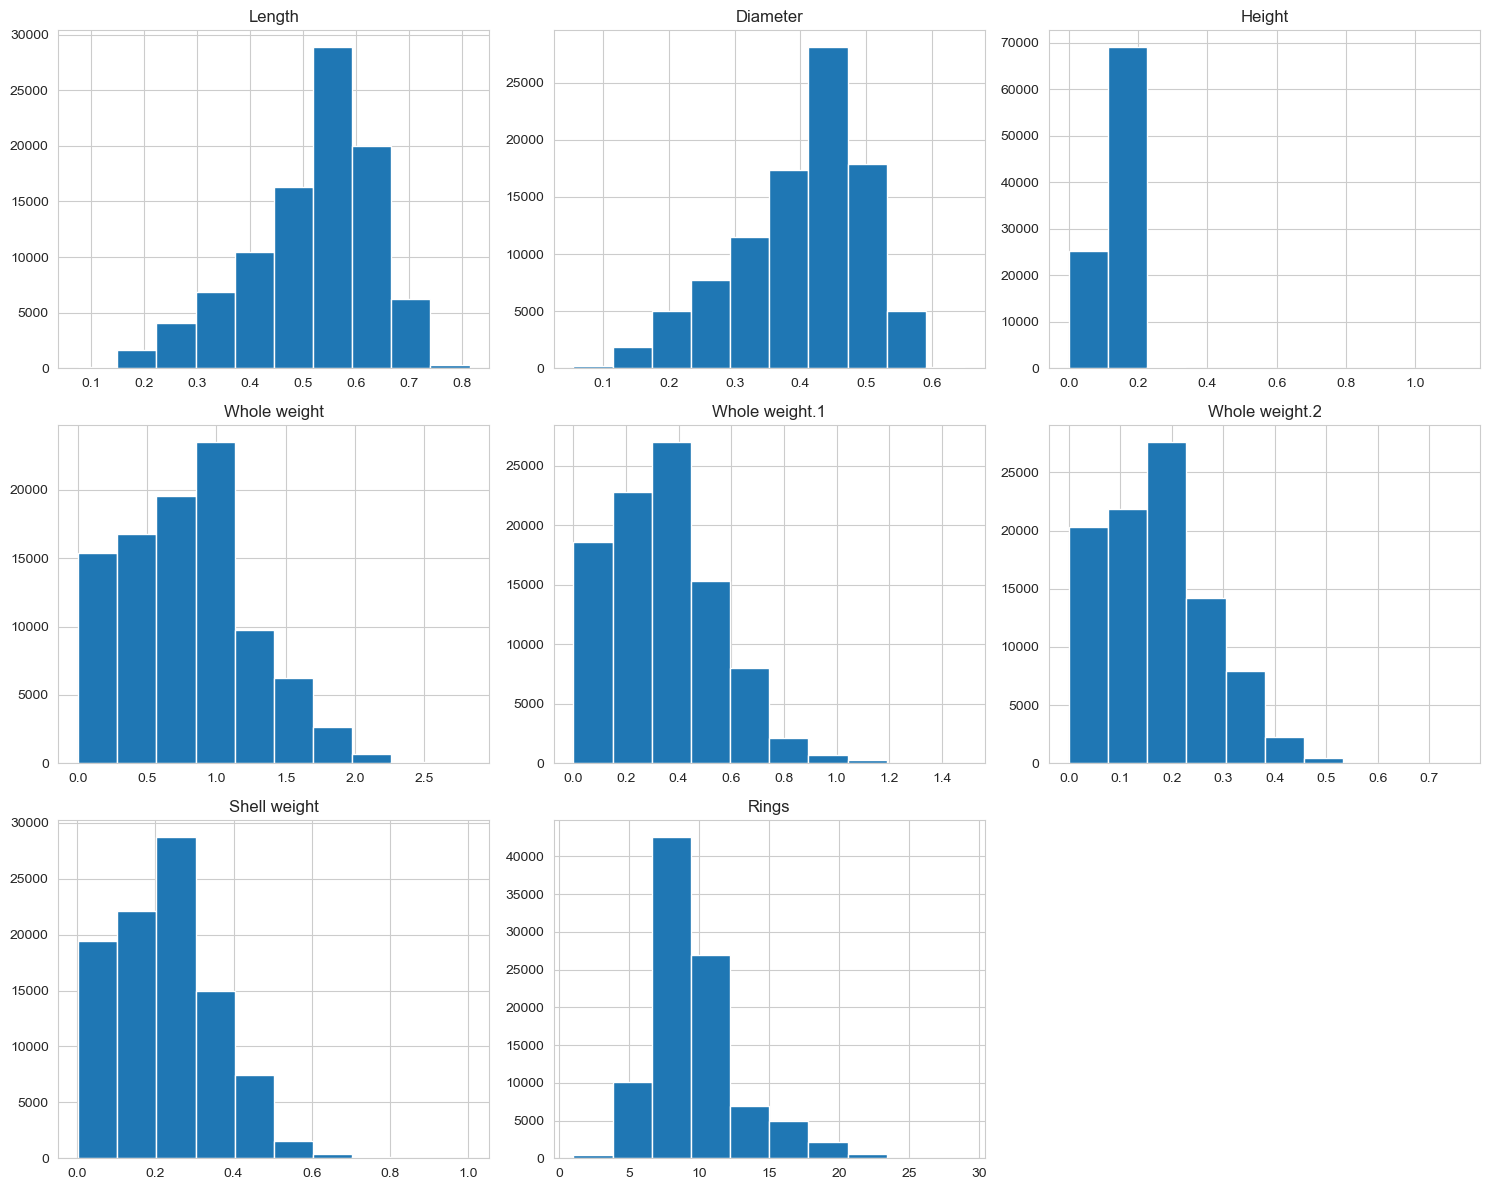

In [14]:
df.hist(figsize=(15, 12))
plt.tight_layout()
plt.show()

In [15]:
skew_coefficients = df[numerical_columns].skew()
skew_coefficients

Length           -0.727373
Diameter         -0.690925
Height            0.475841
Whole weight      0.436328
Whole weight.1    0.601075
Whole weight.2    0.485542
Shell weight      0.488303
Rings             1.200004
dtype: float64

## Correlation

In [16]:
# Create copy for correlation calculation
correlation_df = df.copy()

# Convert to use corr function
correlation_df.Sex = correlation_df.Sex.astype('category').cat.codes

# Create no target correlation matrix dataframe
no_target_df = correlation_df.drop('Rings', axis=1)

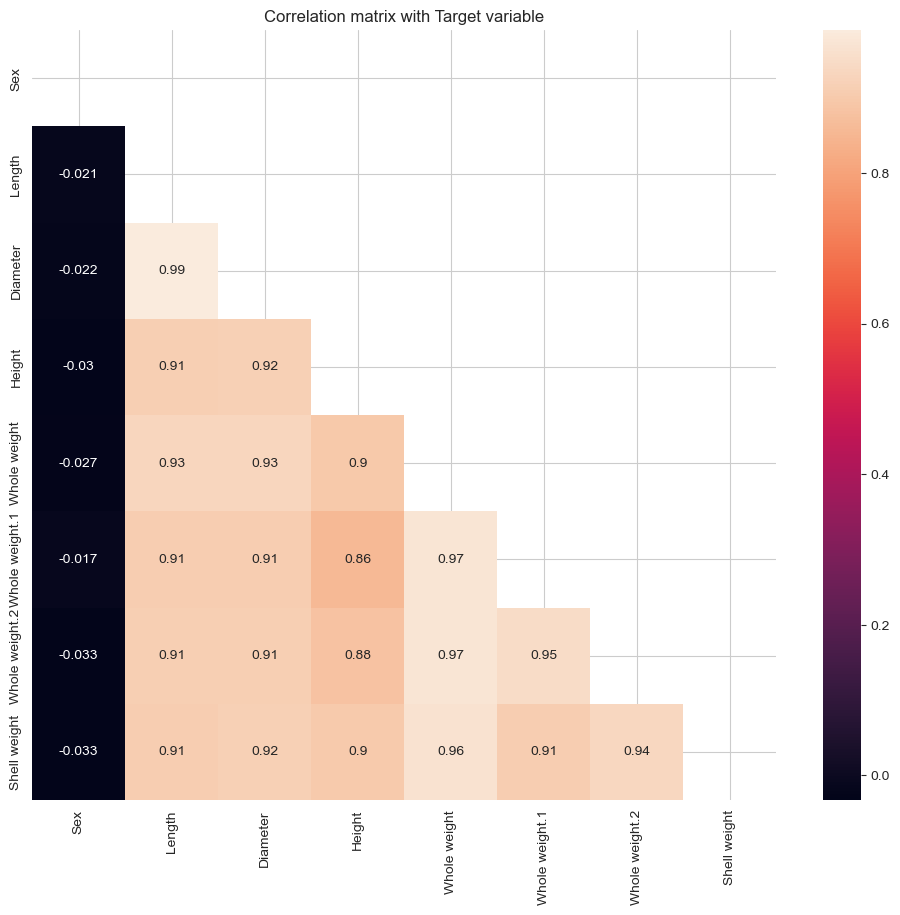

In [17]:
without_target_corr_matrix = no_target_df.corr()

# Create a mask for the upper triangle
mask_up_tri = np.triu(np.ones_like(without_target_corr_matrix, dtype=bool))

plt.figure(figsize=(12, 10))
sns.heatmap(without_target_corr_matrix.round(3), annot=True, mask=mask_up_tri)
plt.title("Correlation matrix with Target variable")
plt.show()

In [18]:
# Calculate the correlation matrix with target
correlation_df.corr().abs()["Rings"].sort_values(ascending=False)

Rings             1.000000
Shell weight      0.691610
Height            0.660468
Diameter          0.634092
Length            0.620809
Whole weight      0.613666
Whole weight.2    0.584903
Whole weight.1    0.510597
Sex               0.026677
Name: Rings, dtype: float64

# Pre-processing

In [19]:
features = df.drop('Rings', axis=1)
target = df['Rings']

In [20]:
X_train, X_test, y_train, y_test = train_test_split(
    features, target, test_size=0.2, random_state=SEED, stratify=target, shuffle=True
)

# Check the shape of the train and test data
print(f"Train data shape: {X_train.shape}, {y_train.shape}")
print(f"Test data shape: {X_test.shape}, {y_test.shape}")

Train data shape: (75833, 8), (75833,)
Test data shape: (18959, 8), (18959,)


# Feature engineering

In [31]:
processor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), NUMERICAL_COLS),
        ('cat', OneHotEncoder(handle_unknown="ignore"), CATEGORICAL_COL)
    ], remainder='passthrough'
)

In [32]:
X_train_processed = processor.fit_transform(X_train)
X_test_processed = processor.transform(X_test)

# Metric

# Modeling

In [33]:
# Create XGBoost regressor
xgb_reg = XGBRegressor()
xgb_reg.fit(X_train_processed, y_train)

# Create CatBoost regressor
catboost_reg = CatBoostRegressor()
catboost_reg.fit(X_train_processed, y_train)

# Create AdaBoost regressor
adaboost_reg = AdaBoostRegressor()
adaboost_reg.fit(X_train_processed, y_train)

Learning rate set to 0.081133
0:	learn: 3.0544635	total: 4.15ms	remaining: 4.15s
1:	learn: 2.9441571	total: 7.18ms	remaining: 3.58s
2:	learn: 2.8402674	total: 10.1ms	remaining: 3.36s
3:	learn: 2.7460932	total: 13.6ms	remaining: 3.38s
4:	learn: 2.6630894	total: 16.7ms	remaining: 3.33s
5:	learn: 2.5897270	total: 19.9ms	remaining: 3.3s
6:	learn: 2.5248448	total: 22.7ms	remaining: 3.22s
7:	learn: 2.4723581	total: 25.5ms	remaining: 3.17s
8:	learn: 2.4234465	total: 28.6ms	remaining: 3.15s
9:	learn: 2.3754570	total: 31.3ms	remaining: 3.1s
10:	learn: 2.3326576	total: 34.1ms	remaining: 3.07s
11:	learn: 2.2944919	total: 37ms	remaining: 3.05s
12:	learn: 2.2612893	total: 40.1ms	remaining: 3.04s
13:	learn: 2.2299037	total: 42.9ms	remaining: 3.02s
14:	learn: 2.2026289	total: 45.8ms	remaining: 3.01s
15:	learn: 2.1786152	total: 48.5ms	remaining: 2.98s
16:	learn: 2.1571538	total: 59.4ms	remaining: 3.43s
17:	learn: 2.1374965	total: 77.3ms	remaining: 4.22s
18:	learn: 2.1205622	total: 84.2ms	remaining: 4.

AdaBoostRegressor()

# Evaluation

In [34]:
y_pred_xgb = xgb_reg.predict(X_test_processed)
y_pred_catboost = catboost_reg.predict(X_test_processed)
y_pred_adaboost = adaboost_reg.predict(X_test_processed)

In [35]:
print(f"XGBoost RMSLE: {mean_squared_log_error(y_test, y_pred_xgb, squared=False)}")
print(f"CatBoost RMSLE: {mean_squared_log_error(y_test, y_pred_catboost, squared=False)}")
print(f"AdaBoost RMSLE: {mean_squared_log_error(y_test, y_pred_adaboost, squared=False)}")

XGBoost RMSLE: 0.1508197880684061
CatBoost RMSLE: 0.14936157341507805
AdaBoost RMSLE: 0.27772595857303434


# Prediction & Submission

In [36]:
test = pd.read_csv('data/test.csv')
sub = pd.read_csv('data/sample_submission.csv')

In [37]:
to_pred = test.drop('id', axis=1)

to_pred_processed = processor.transform(to_pred)

In [38]:
predictions = xgb_reg.predict(to_pred_processed)
sub["Rings"] = predictions
sub.to_csv("submission.csv", index=False)

# Reference